In [3]:
# Import tensorflow and additional libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

tf.keras.backend.clear_session()

# Check version
print('tensorflow version: ', tf.__version__)

tensorflow version:  2.8.0


In [4]:
# Load : Fashion MNIST Dataest
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

size_of_train  = len(x_train)
size_of_test  = len(x_test)
num_of_class = 10

print('The Shape of dataset:', x_train[0].shape)
print('The number of train image:', size_of_train)
print('The number of test image:', size_of_test)

4431872/4422102 [==============================] - 0s 0us/step
The Shape of dataset: (28, 28)
The number of train image: 60000
The number of test image: 10000


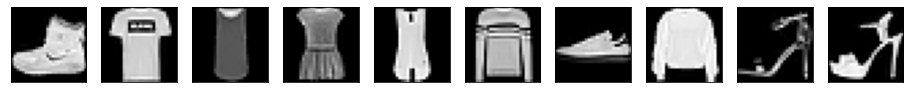

In [5]:
# Train Data
plt.figure(figsize=(16, 10))
for i in range(num_of_class):
    ax = plt.subplot(1, num_of_class, i+1)
    plt.imshow(x_train[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [6]:
print('== Before normalization ==')
print('Image Shape:', x_train[0].shape)
print('Value MIN: %d, MEAN:%.2f, MAX:%d'%(np.min(x_train[0]), np.mean(x_train[0]), np.max(x_train[0])))

## Dataset Pre-processing ##
# Normalization
x_train = x_train/255.  
x_test = x_test/255. 

# Reshape(Adding channel)
x_train = x_train.reshape((size_of_train, 28, 28, 1))
x_test = x_test.reshape((size_of_test, 28, 28, 1))

print('\n== After normalization ==')
print('Image Shape:', x_train[0].shape)
print('Value MIN: %d, MEAN:%.2f, MAX:%d'%(np.min(x_train[0]), np.mean(x_train[0]), np.max(x_train[0])))

== Before normalization ==
Image Shape: (28, 28)
Value MIN: 0, MEAN:97.25, MAX:255

== After normalization ==
Image Shape: (28, 28, 1)
Value MIN: 0, MEAN:0.38, MAX:1


In [7]:
def channel_attention(x, channels, name):
    ####Fill your code####
    F_in = x
    r = 4
    F_in = tf.keras.layers.GlobalAveragePooling2D()(F_in)
    F_in = tf.keras.layers.Dense(channels//r)(F_in)
    F_in = tf.keras.layers.BatchNormalization()(F_in)
    F_in = tf.keras.layers.ReLU()(F_in)
    F_in = tf.keras.layers.Dense(channels, activation='sigmoid')(F_in)
    F_out = x * F_in[:, None, None]

    return  F_out

def spatial_attention(x, channels, name):
    ####Fill your code####
    F_in = x
    r = 4
    F_in = tf.keras.layers.Conv2D(filters=channels//r, kernel_size=1, strides=(1,1), padding='same')(F_in)
    F_in = tf.keras.layers.BatchNormalization()(F_in)
    F_in = tf.keras.layers.ReLU()(F_in)
    F_in = tf.keras.layers.Conv2D(filters=channels//r, kernel_size=3, strides=(1,1), padding='same')(F_in)
    F_in = tf.keras.layers.BatchNormalization()(F_in)
    F_in = tf.keras.layers.ReLU()(F_in)
    F_in = tf.keras.layers.Conv2D(filters=channels//r, kernel_size=3, strides=(1,1), padding='same')(F_in)
    F_in = tf.keras.layers.BatchNormalization()(F_in)
    F_in = tf.keras.layers.ReLU()(F_in)
    F_in = tf.keras.layers.Conv2D(1, kernel_size=1, strides=(1,1), padding='same', activation='sigmoid')(F_in)
    F_out = x * F_in

    return  F_out
 
def autoencoder_block(x, filter, name): 
    x = tf.keras.layers.Conv2D(filters=filter, kernel_size=3, strides=(1, 1), padding='same', name=name+'_conv')(x)
    x = tf.keras.layers.BatchNormalization(name=name+'_bn')(x)
    x = tf.keras.layers.ReLU(name=name+'_relu')(x)
    return x

In [8]:
##############################################
# Add Attention Block in AutoEncoder network #
##############################################

def autoencoder(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    
    encoded_img = autoencoder_block(x, 64, 'encoder3')

    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')
 
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img

def autoencoder_channel(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')

    x = channel_attention(x, 16, 'channel_attention1')
    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')

    x = channel_attention(x, 32, 'channel_attention2')
    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    
    encoded_img = autoencoder_block(x, 64, 'encoder3')

    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')

    x = channel_attention(x, 64, 'channel_attention3')
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')
 
    x = channel_attention(x, 32, 'channel_attention4')
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img 


def autoencoder_spatial(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')
    
    x = spatial_attention(x, 16, 'spatial_attention1')
    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')

    x = spatial_attention(x, 32, 'spatial_attention2')
    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    
    encoded_img = autoencoder_block(x, 64, 'encoder3')

    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')

    x = spatial_attention(x, 64, 'spatial_attention3')
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')

    x = spatial_attention(x, 32, 'spatial_attention4')
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img     


def autoencoder_parallel_add(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')
    
    x_channel = channel_attention(x, 16, 'channel_attention1')
    x_spatial = spatial_attention(x, 16, 'spatial_attention1')
    x = tf.keras.layers.add([x_channel, x_spatial])
    
    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')

    x_channel = channel_attention(x, 32, 'channel_attention2')
    x_spatial = spatial_attention(x, 32, 'spatial_attention2')
    x = tf.keras.layers.add([x_channel, x_spatial])

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    
    encoded_img = autoencoder_block(x, 64, 'encoder3')

    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')

    x_channel = channel_attention(x, 64, 'channel_attention3')
    x_spatial = spatial_attention(x, 64, 'spatial_attention3')
    x = tf.keras.layers.add([x_channel, x_spatial])

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')

    x_channel = channel_attention(x, 32, 'channel_attention4')
    x_spatial = spatial_attention(x, 32, 'spatial_attention4')
    x = tf.keras.layers.add([x_channel, x_spatial])

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img    


def autoencoder_parallel_mul(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')
    
    x_channel = channel_attention(x, 16, 'channel_attention1')
    x_spatial = spatial_attention(x, 16, 'spatial_attention1')
    x = tf.keras.layers.Multiply()([x_channel, x_spatial])
    
    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')

    x_channel = channel_attention(x, 32, 'channel_attention2')
    x_spatial = spatial_attention(x, 32, 'spatial_attention2')
    x = tf.keras.layers.Multiply()([x_channel, x_spatial])

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    
    encoded_img = autoencoder_block(x, 64, 'encoder3')

    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')

    x_channel = channel_attention(x, 64, 'channel_attention3')
    x_spatial = spatial_attention(x, 64, 'spatial_attention3')
    x = tf.keras.layers.Multiply()([x_channel, x_spatial])

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')

    x_channel = channel_attention(x, 32, 'channel_attention4')
    x_spatial = spatial_attention(x, 32, 'spatial_attention4')
    x = tf.keras.layers.Multiply()([x_channel, x_spatial])

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img

def autoencoder_serial_channel_spatial(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')
    
    x = channel_attention(x, 16, 'channel_attention1')
    x = spatial_attention(x, 16, 'spatial_attention1')
    
    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')

    x = channel_attention(x, 32, 'channel_attention2')
    x = spatial_attention(x, 32, 'spatial_attention2')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    
    encoded_img = autoencoder_block(x, 64, 'encoder3')

    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')

    x = channel_attention(x, 64, 'channel_attention3')
    x = spatial_attention(x, 64, 'spatial_attention3')

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')

    x = channel_attention(x, 32, 'channel_attention4')
    x = spatial_attention(x, 32, 'spatial_attention4')

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img

def autoencoder_serial_spatial_channel(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')
    
    x = spatial_attention(x, 16, 'spatial_attention1')
    x = channel_attention(x, 16, 'channel_attention1')
    
    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')

    x = spatial_attention(x, 32, 'spatial_attention2')
    x = channel_attention(x, 32, 'channel_attention2')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    
    encoded_img = autoencoder_block(x, 64, 'encoder3')

    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')

    x = spatial_attention(x, 64, 'spatial_attention3')
    x = channel_attention(x, 64, 'channel_attention3')

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')

    x = spatial_attention(x, 32, 'spatial_attention4')
    x = channel_attention(x, 32, 'channel_attention4')

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img 


In [9]:
# Normal AutoEncoder Model Create / Summary
input_data = tf.keras.Input(shape=(28, 28, 1))

output_data = autoencoder(input_data)
output_channel_data = autoencoder_channel(input_data)
output_spatial_data = autoencoder_spatial(input_data)
output_parellel_add_data = autoencoder_parallel_add(input_data)
output_parellel_mul_data = autoencoder_parallel_mul(input_data)
output_serial_channel_spatial_data = autoencoder_serial_channel_spatial(input_data)
output_serial_spatial_channel_data = autoencoder_serial_spatial_channel(input_data)

model = tf.keras.Model(inputs=input_data, outputs=output_data)
model_channel = tf.keras.Model(inputs=input_data, outputs=output_channel_data)
model_spatial = tf.keras.Model(inputs=input_data, outputs=output_spatial_data)
model_parellel_add = tf.keras.Model(inputs=input_data, outputs=output_parellel_add_data)
model_parellel_mul = tf.keras.Model(inputs=input_data, outputs=output_parellel_mul_data)
model_serial_channel_spatial = tf.keras.Model(inputs=input_data, outputs=output_serial_channel_spatial_data)
model_serial_spatial_channel = tf.keras.Model(inputs=input_data, outputs=output_serial_spatial_channel_data)

model.summary()
model_channel.summary()
model_spatial.summary()
model_parellel_add.summary()
model_parellel_mul.summary()
model_serial_channel_spatial.summary()
model_serial_spatial_channel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder1_conv (Conv2D)      (None, 28, 28, 16)        160       
                                                                 
 encoder1_bn (BatchNormaliza  (None, 28, 28, 16)       64        
 tion)                                                           
                                                                 
 encoder1_relu (ReLU)        (None, 28, 28, 16)        0         
                                                                 
 encoder_pool1 (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 encoder2_conv (Conv2D)      (None, 14, 14, 32)        4640  

In [10]:
# Model Compile
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])
model_channel.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])
model_spatial.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])
model_parellel_add.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])
model_parellel_mul.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])
model_serial_channel_spatial.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])
model_serial_spatial_channel.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])

In [17]:
# Training
epoch = 10

# AutoEncoder는 input과 output이 같으므로 x_train을 넣어줌
print('Training Model')
history = model.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=epoch,
                    shuffle=True,
                    validation_data=(x_test, x_test))

Training Model
Epoch 1/10
3750/3750 [==============================] - 274s 73ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 2/10
3750/3750 [==============================] - 270s 72ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 3/10
3750/3750 [==============================] - 271s 72ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 4/10
3750/3750 [==============================] - 270s 72ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 5/10
3750/3750 [==============================] - 270s 72ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 6/10
3750/3750 [==============================] - 268s 72ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 7/10
3750/3750 [==============================] - 274s 73ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 8/10
3750/3750 [====

In [23]:
print('Training Model - channel')
epoch = 10
history_channel = model_channel.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=epoch,
                    shuffle=True,
                    validation_data=(x_test, x_test))

Training Model - channel
Epoch 1/10
3750/3750 [==============================] - 287s 76ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 2/10
3750/3750 [==============================] - 278s 74ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 3/10
3750/3750 [==============================] - 279s 74ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 4/10
3750/3750 [==============================] - 278s 74ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 5/10
3750/3750 [==============================] - 279s 74ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 6/10
3750/3750 [==============================] - 276s 74ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 7/10
3750/3750 [==============================] - 286s 76ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 8/10
3750/

In [30]:
print('Training Model - spatial')
epoch = 10
history_spatial = model_spatial.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=epoch,
                    shuffle=True,
                    validation_data=(x_test, x_test))

Training Model - spatial
Epoch 1/10
3750/3750 [==============================] - 423s 112ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 2/10
3750/3750 [==============================] - 401s 107ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 3/10
3750/3750 [==============================] - 403s 108ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 4/10
3750/3750 [==============================] - 401s 107ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 5/10
3750/3750 [==============================] - 402s 107ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 6/10
3750/3750 [==============================] - 404s 108ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 7/10
3750/3750 [==============================] - 404s 108ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 8/1

In [11]:
print('Training Model - parellel_add')
epoch = 10
history_parallel_add = model_parellel_add.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=epoch,
                    shuffle=True,
                    validation_data=(x_test, x_test))

Training Model - parellel_add
Epoch 1/10
3750/3750 [==============================] - 60s 13ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 2/10
3750/3750 [==============================] - 47s 13ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 3/10
3750/3750 [==============================] - 54s 14ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 4/10
3750/3750 [==============================] - 48s 13ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 5/10
3750/3750 [==============================] - 47s 13ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 6/10
3750/3750 [==============================] - 47s 12ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 7/10
3750/3750 [==============================] - 47s 12ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 8/10
3750/37

In [17]:
print('Training Model - parellel_mul')
epoch = 10
history_parallel_mul = model_parellel_mul.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=epoch,
                    shuffle=True,
                    validation_data=(x_test, x_test))

Training Model - parellel_mul
Epoch 1/10
3750/3750 [==============================] - 55s 14ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 2/10
3750/3750 [==============================] - 48s 13ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 3/10
3750/3750 [==============================] - 48s 13ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 4/10
3750/3750 [==============================] - 48s 13ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 5/10
3750/3750 [==============================] - 47s 13ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 6/10
3750/3750 [==============================] - 47s 13ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 7/10
3750/3750 [==============================] - 47s 13ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 8/10
3750/37

In [22]:
print('Training Model - serial_channel_spatial')
epoch = 10
history_serial_channel_spatial = model_serial_channel_spatial.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=epoch,
                    shuffle=True,
                    validation_data=(x_test, x_test))

Training Model - serial_channel_spatial
Epoch 1/10
3750/3750 [==============================] - 49s 12ms/step - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 2/10
3750/3750 [==============================] - 47s 13ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 3/10
3750/3750 [==============================] - 46s 12ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 4/10
3750/3750 [==============================] - 46s 12ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 5/10
3750/3750 [==============================] - 46s 12ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 6/10
3750/3750 [==============================] - 46s 12ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 7/10
3750/3750 [==============================] - 46s 12ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 8/

In [27]:
print('Training Model - serial_spatial_channel')
epoch = 10
history_serial_spatial_channel = model_serial_spatial_channel.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=epoch,
                    shuffle=True,
                    validation_data=(x_test, x_test))

Training Model - serial_spatial_channel
Epoch 1/10
3750/3750 [==============================] - 50s 13ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 2/10
3750/3750 [==============================] - 46s 12ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 3/10
3750/3750 [==============================] - 46s 12ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 4/10
3750/3750 [==============================] - 46s 12ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 5/10
3750/3750 [==============================] - 46s 12ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 6/10
3750/3750 [==============================] - 46s 12ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 7/10
3750/3750 [==============================] - 46s 12ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 8/

In [18]:
# Model Predict
recons = model.predict(x_test)

In [24]:
# Model Predict
recons_channel = model_channel.predict(x_test)

In [31]:
# Model Predict
recons_spatial = model_spatial.predict(x_test)

In [12]:
# Model Predict
recons_parallel_add = model_parellel_add.predict(x_test)

In [18]:
# Model Predict
recons_parallel_mul = model_parellel_mul.predict(x_test)

In [23]:
# Model Predict
recons_serial_channel_spatial = model_serial_channel_spatial.predict(x_test)

In [28]:
# Model Predict
recons_serial_spatial_channel = model_serial_spatial_channel.predict(x_test)

In [ ]:
recons = recons.reshape(-1, 28, 28)
recons_channel = recons_channel.reshape(-1, 28, 28)
recons_spatial = recons_spatial.reshape(-1, 28, 28)

In [29]:
recons_parallel_add = recons_parallel_add.reshape(-1, 28, 28)
recons_parallel_mul = recons_parallel_mul.reshape(-1, 28, 28)
recons_serial_channel_spatial = recons_serial_channel_spatial.reshape(-1, 28, 28)
recons_serial_spatial_channel = recons_serial_spatial_channel.reshape(-1, 28, 28)

In [26]:
test_imgs = (x_test * 255).reshape(-1, 28, 28)

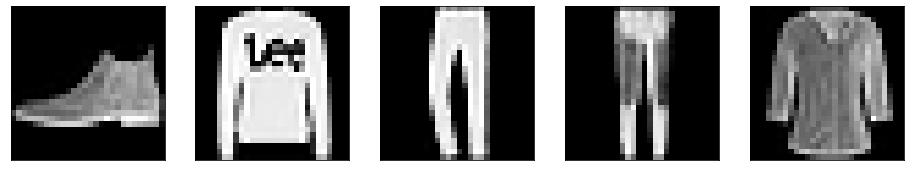

In [20]:
# Test Data Visualization
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(test_imgs[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

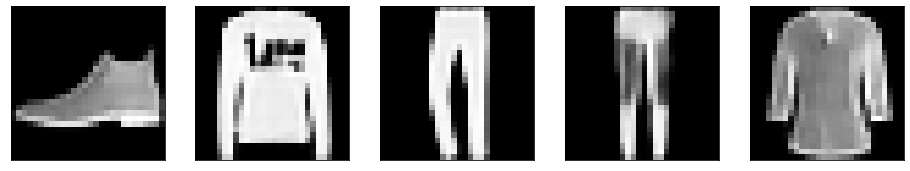

In [21]:
# Predictions Visualization
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

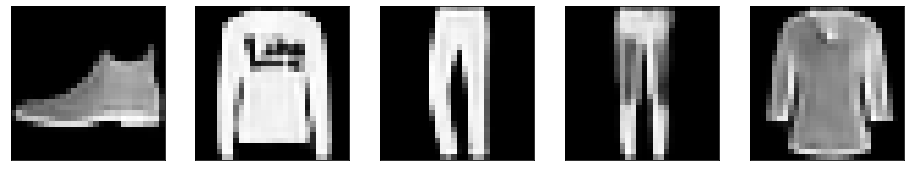

In [27]:
# Predictions Visualization - channel
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_channel[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

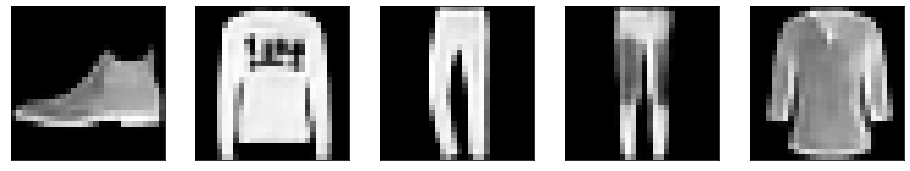

In [33]:
# Predictions Visualization - spatial
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_spatial[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

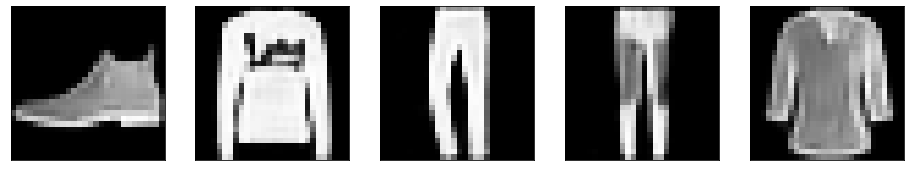

In [15]:
# Predictions Visualization - parellel_add
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_parallel_add[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

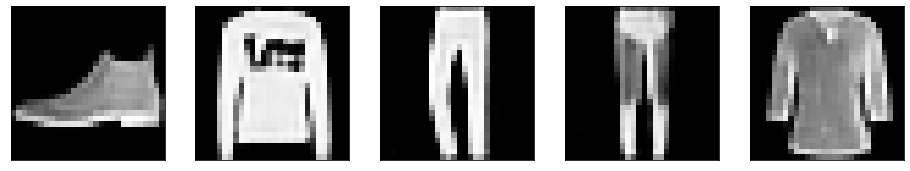

In [20]:
# Predictions Visualization - parellel_mul
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_parallel_mul[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

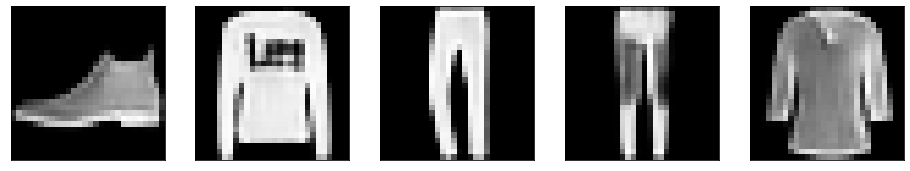

In [25]:
# Predictions Visualization - serial_channel_spatial
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_serial_channel_spatial[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

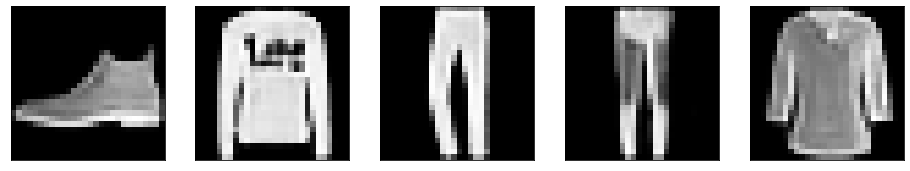

In [30]:
#Predictions Visualization - serial_spatial_channel
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_serial_spatial_channel[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

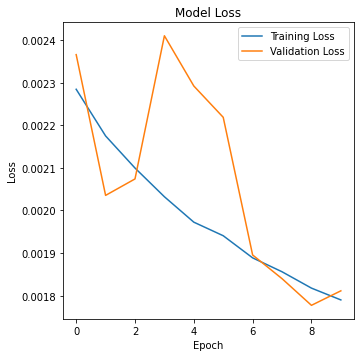

In [22]:
plt.figure(figsize=(24, 12))

plt.subplot(2,4,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

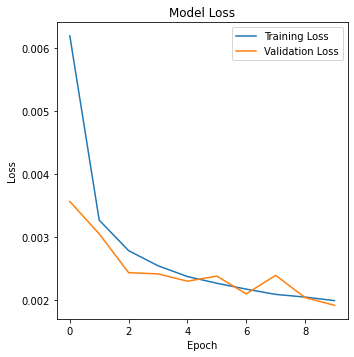

In [29]:
plt.figure(figsize=(24, 12))

plt.subplot(2,4,2)
plt.plot(history_channel.history['loss'])
plt.plot(history_channel.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)
plt.show()

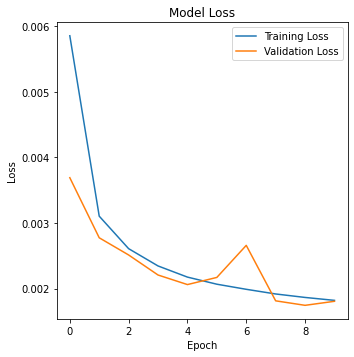

In [34]:
plt.figure(figsize=(24, 12))

plt.subplot(2,4,3)
plt.plot(history_spatial.history['loss'])
plt.plot(history_spatial.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.show()

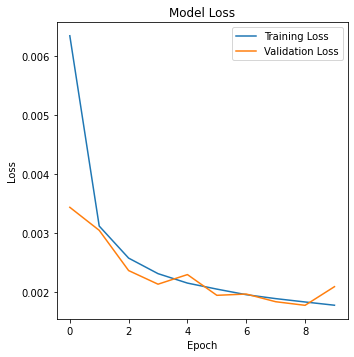

In [16]:
plt.figure(figsize=(24, 12))

plt.subplot(2,4,4)
plt.plot(history_parallel_add.history['loss'])
plt.plot(history_parallel_add.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.show()

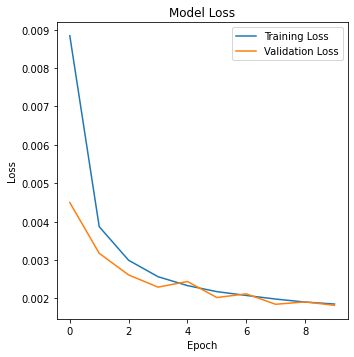

In [21]:
plt.figure(figsize=(24, 12))

plt.subplot(2,4,5)
plt.plot(history_parallel_mul.history['loss'])
plt.plot(history_parallel_mul.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.show()

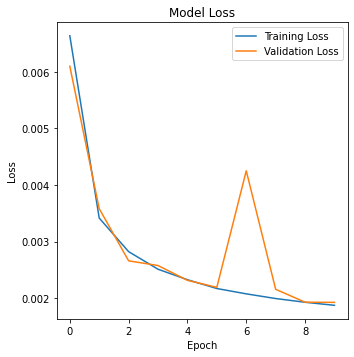

In [26]:
plt.figure(figsize=(24, 12))

plt.subplot(2,4,6)
plt.plot(history_serial_channel_spatial.history['loss'])
plt.plot(history_serial_channel_spatial.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.show()

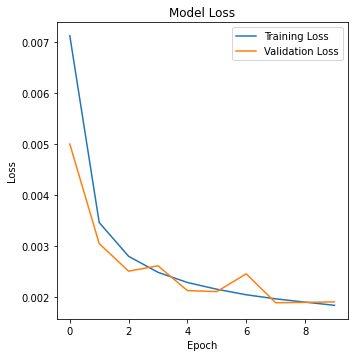

In [31]:
plt.figure(figsize=(24, 12))

plt.subplot(2,4,7)
plt.plot(history_serial_spatial_channel.history['loss'])
plt.plot(history_serial_spatial_channel.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.show()